<a href="https://colab.research.google.com/github/anuda/EVA8/blob/main/S4/Assignment4_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target
- Build on top of the 1st approach
- Introduce Batch normalization,  GAP , 1X1 convolutions for channel selection
- Add drop out to reduce overfit 
- Increase mo
- Reduce the number of parameters to 15k-20k
- Target test/val accuracy to be clsoe to 98-99% 
- Reduce # epcohs to 10

## Results
- Best training accuracy: 99.09
- Best test accuracy: 98.73
- 
## Analysis
- Model seems to be overfit to some extent
- It is a lighter model with **18.1K** parameters
- It is quite evident from the data that we need augmentation applied to the data
- there are cases where the numbers are tilted

### Import Libraries

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### define transformations 
- use them while downloading data

In [13]:
train_transform = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize()
])



In [14]:
train = datasets.MNIST('./data',train=True, download=True, transform=train_transform)



#### Compute mean and std deviation for image normalization

In [15]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#### Update transformation using mean and std from the training data

In [16]:
train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,),std=(0.3081,))
])


test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,),std=(0.3081,))
])



### Apply transformation to both train and test dataset

In [17]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [18]:
type(train)

torchvision.datasets.mnist.MNIST

### Create Dataloader for batch generation

In [19]:
SEED = 1
cuda = torch.cuda.is_available()
print(cuda)

False


In [20]:
#for reproducibility
torch.cuda.manual_seed(SEED)


In [21]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Show few images
- Create a data iter object
- fetch a batch of data using data loader

In [22]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

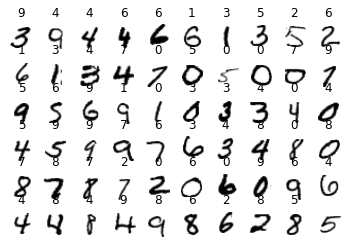

In [24]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.title(str(labels[index].item()))
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Create a Model
- will create like 5-7 layers of networks
- not use padding
- channels to be a minimal in number
- create multiple sequential blocks
- 28X28 > 26X26 > 24X24 > 22X22 > MP (11X11) > 9X9 > 7X7 > 1X1

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
            
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
            
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
            
        )
        self.pool1 = nn.MaxPool2d(2,2)
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
            
        )
        #create a transition 
        
        
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        )
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        )
        
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.05)
        
        
    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        
        
        x = self.convblock5(x)
        x = self.dropout(x)
        # return x
        # x = self.convblock6(x)
        x = self.gap(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x,dim=-1)
            

### Visualize the model

In [26]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 32, 22, 22]           4,608
       BatchNorm2d-8           [-1, 32, 22, 22]              64
              ReLU-9           [-1, 32, 22, 22]               0
          Dropout-10           [-1, 32, 22, 22]               0
        MaxPool2d-11           [-1, 32, 11, 11]               0
           Conv2d-12             [-1, 32, 9, 9]           9,216
      BatchNorm2d-13             [-1, 32, 9, 9]              64
             ReLU-14             [-

### Training the Model

In [30]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_ep_loss=0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(data)
        
        loss = F.nll_loss(y_pred, target)
        train_ep_loss+=loss
        train_losses.append(loss)
        
        loss.backward() #backward prop
        optimizer.step()
        
        pred = y_pred.argmax(dim=1, keepdim=True)
        
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc=f'Loss = {loss.item()} Batch_id = {batch_idx}\
            Accuracy={100*correct/processed:0.2f}')
        
        
        train_acc.append(100*correct/processed)

        
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
            
        
        

In [31]:
len(test_loader.dataset)

10000

In [32]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


EPOCH: 0


Loss = 0.2034590244293213 Batch_id = 468            Accuracy=90.56: 100%|██████████| 469/469 [01:05<00:00,  7.13it/s]



Test set: Average loss: 0.2130, Accuracy: 9719/10000 (97.19%)

EPOCH: 1


Loss = 0.15882523357868195 Batch_id = 468            Accuracy=97.66: 100%|██████████| 469/469 [01:05<00:00,  7.11it/s]



Test set: Average loss: 0.1372, Accuracy: 9727/10000 (97.27%)

EPOCH: 2


Loss = 0.1376846581697464 Batch_id = 468            Accuracy=98.22: 100%|██████████| 469/469 [01:06<00:00,  7.04it/s]



Test set: Average loss: 0.1161, Accuracy: 9757/10000 (97.57%)

EPOCH: 3


Loss = 0.045589838176965714 Batch_id = 468            Accuracy=98.47: 100%|██████████| 469/469 [01:07<00:00,  6.95it/s]



Test set: Average loss: 0.0787, Accuracy: 9840/10000 (98.40%)

EPOCH: 4


Loss = 0.10609180480241776 Batch_id = 468            Accuracy=98.71: 100%|██████████| 469/469 [01:07<00:00,  6.97it/s]



Test set: Average loss: 0.0947, Accuracy: 9766/10000 (97.66%)

EPOCH: 5


Loss = 0.12204127758741379 Batch_id = 468            Accuracy=98.85: 100%|██████████| 469/469 [01:06<00:00,  7.10it/s]



Test set: Average loss: 0.0877, Accuracy: 9773/10000 (97.73%)

EPOCH: 6


Loss = 0.1334335058927536 Batch_id = 468            Accuracy=98.86: 100%|██████████| 469/469 [01:06<00:00,  7.10it/s]



Test set: Average loss: 0.0571, Accuracy: 9867/10000 (98.67%)

EPOCH: 7


Loss = 0.09720033407211304 Batch_id = 468            Accuracy=98.99: 100%|██████████| 469/469 [01:07<00:00,  6.95it/s]



Test set: Average loss: 0.0558, Accuracy: 9859/10000 (98.59%)

EPOCH: 8


Loss = 0.02447812259197235 Batch_id = 468            Accuracy=99.00: 100%|██████████| 469/469 [01:05<00:00,  7.12it/s]



Test set: Average loss: 0.0600, Accuracy: 9854/10000 (98.54%)

EPOCH: 9


Loss = 0.035829368978738785 Batch_id = 468            Accuracy=99.09: 100%|██████████| 469/469 [01:05<00:00,  7.11it/s]



Test set: Average loss: 0.0521, Accuracy: 9873/10000 (98.73%)

